In [1]:
from astropy.table import Table
import matplotlib.pyplot as plt
import matplotlib
import MegaScreen
import numpy as np
import scipy.integrate
from test_Noll import Noll
import functools
from MegaScreen import VonKarmanSpectrum, NestedSpectra

%matplotlib inline
matplotlib.rcParams['savefig.dpi'] = 200
matplotlib.rcParams['text.usetex'] = False

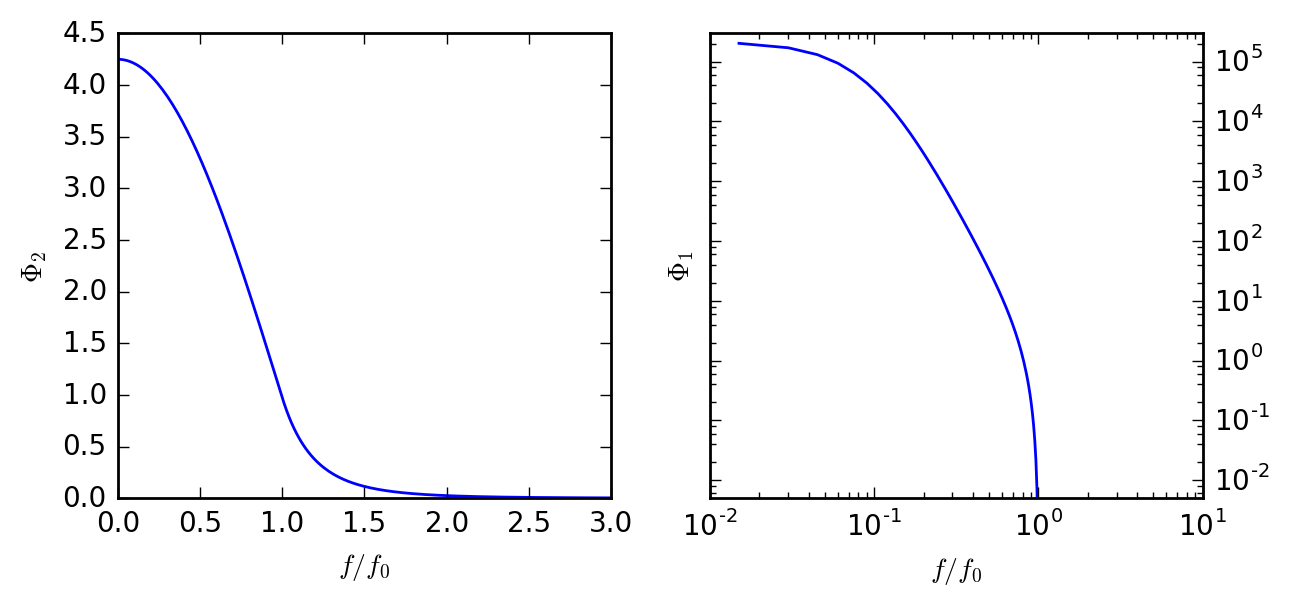

In [2]:
def spectrum(f):
    return (f**2+0.1**2)**(-8/3)
inner,outer=NestedSpectra(spectrum,f0=1)

plt.figure(figsize=(7,3))
plt.subplot(1,2,1)
f=np.linspace(0,3,200)
plt.plot(f,outer(f))
plt.xlabel("$f/f_0$")
plt.ylabel(r"$\Phi_2$")
#plt.title("Tweeter")
plt.subplot(1,2,2)
plt.loglog(f[:-1],inner(f)[:-1])
#plt.title("Woofer")
plt.xlabel("$f/f_0$")
plt.ylabel(r"$\Phi_1$")
plt.ylim(5e-3,3e5)
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left='on',      # ticks along the bottom edge are off
    right='on',         # ticks along the top edge are off
    labelright="on",
    labelleft="off"
    )
matplotlib.rcParams['text.usetex'] = False
plt.savefig("tweetwoof.eps",bbox_inches="tight")

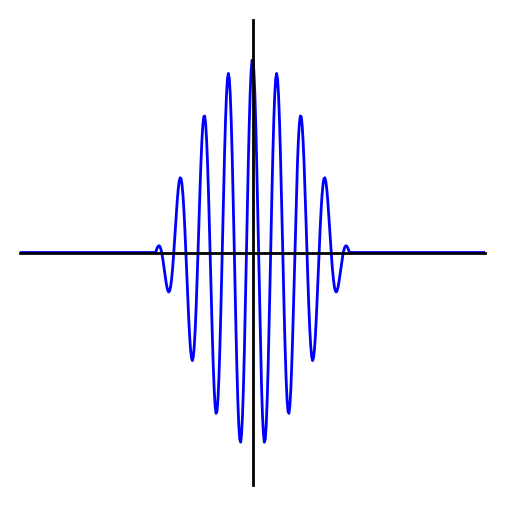

In [5]:
def CosHat(x,w=1):
    y=np.cos(np.pi*x/(w))
    y[np.abs(x)>w/2]=0.0
    return y

def AmplitudeSpectrum(data):
    return np.fft.fftshift(abs(np.fft.fft(data)))

def FftCoords(xmax,nfft):
    deltax=xmax/nfft
    deltaf=1.0/xmax
    x=np.arange(nfft)*deltax    
    f=np.fft.fftfreq(nfft,deltax)
    return x,np.fft.fftshift(f)

def NewCoords(oversampling,nfft):
    x=np.linspace(-oversampling,oversampling,nfft)
    deltax=x[1]-x[0]
    f=np.fft.fftfreq(nfft,deltax)
    return x,np.fft.fftshift(f)

def fftpartialshift(f,a,fshift):
    nfft=len(f)
    deltaf=f[1]-f[0]
    nshift=int(fshift/deltaf)
    indices=(np.arange(nfft)-nshift)%nfft
    return a[indices]

# Specialised for shifted FFTs
def PlotRange(x,y,xmax,normalise=True):
    deltax=x[1]-x[0]
    indices=(abs(x)<xmax)
    if normalise:
        norm=y[x==0]
    else:
        norm=1.0
    plt.plot(x[indices],y[indices]/norm)

def PlotRange2(x,y,xmax):
    deltax=x[1]
    numPlot=int(xmax/deltax)
    plot(x[:numPlot],y[:numPlot])

x,f=NewCoords(5,2048)

def packet(x,f0):
    return np.cos(2*np.pi*f0*x)*CosHat(x)
y=packet(x,8)

plt.figure(figsize=(3,3))
plt.plot(x,y)
plt.xlim(-1.2,1.2)
plt.ylim(-1.2,1.2)
plt.xticks([])
plt.yticks([])
ax = plt.gca()  # gca stands for 'get current axis'
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('data',0))
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data',0))
matplotlib.rcParams['text.usetex'] = True
plt.savefig("packet.eps",bbox_inches="tight")

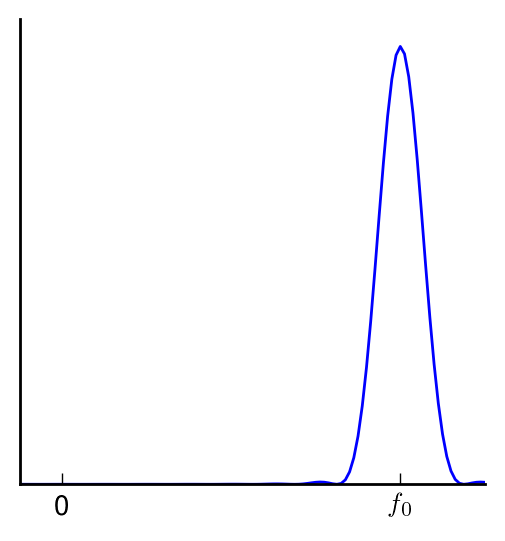

In [11]:
plt.figure(figsize=(3,3))
p=AmplitudeSpectrum(y)**2
plt.plot(f,p)
plt.xlim(-1,10)
plt.yticks([])
plt.xticks([0,8],["0","$f_0$"])
ax=plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    top='off',      # ticks along the bottom edge are off
    bottom='on',         # ticks along the top edge are off
    )

plt.savefig("one_peak.eps",bbox_inches="tight")

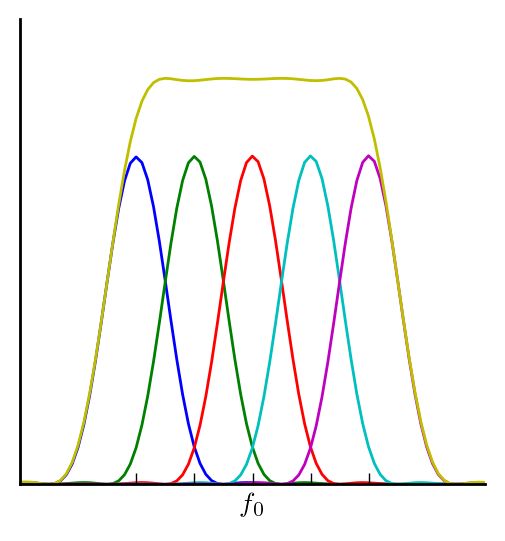

In [12]:
plt.figure(figsize=(3,3))
spectra=np.array([AmplitudeSpectrum(packet(x,f0))**2 for f0 in [5,6,7,8,9]])
for spectrum in spectra:
    plt.plot(f,spectrum)
plt.xlim(3,11)
plt.plot(f,np.sum(spectra,axis=0))
plt.yticks([])
plt.xticks([5,6,7,8,9],[r"","",r"$f_0$","",""])
ax=plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    top='off',      # ticks along the bottom edge are off
    bottom='on',         # ticks along the top edge are off
    )

#plt.grid()
plt.savefig("smoothpeaks.eps",bbox_inches="tight")

/usr/local/lib/python3.5/site-packages/scipy/integrate/quadpack.py:352: IntegrationWarning: The maximum number of subdivisions (400) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


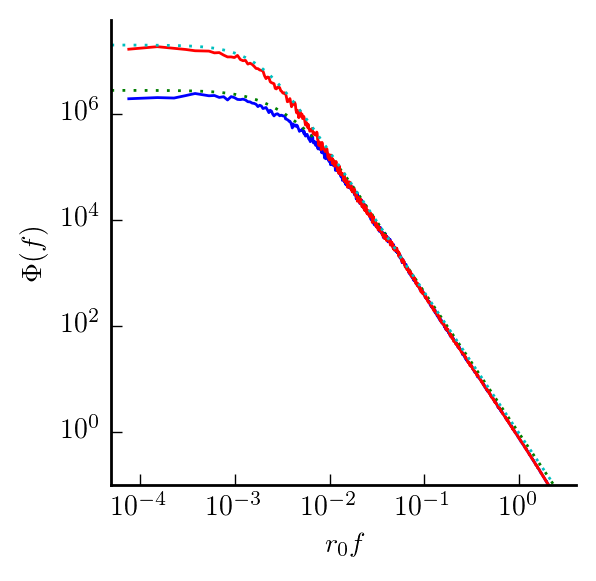

In [20]:
def logbin(x,y,unitbin):
    """
    C UNITBIN is the x-coord at which the bin size is equal to the initial
    C bin size. For samples up to this ordinate, no binning is done, and
    C after this the bin size is the nearest integer to X/UNITBIN where X is
    C the x-coord of the  leftmost initial bin.
    C
    C If last bin has less than a full complement of samples, it IS computed.
    C The number of computed bins is returned in NBIN.
    """
    i=0
    imax=len(x)
    xnew=[]
    ynew=[]
    while i<imax:
        nbin=int(max(1,x[i]/unitbin))
        nbin=min(imax-i,nbin)
        #print(nbin)
        xnew.append(np.sum(x[i:i+nbin])/nbin)
        ynew.append(np.sum(y[i:i+nbin])/nbin)
        i+=nbin
    return np.array(xnew),np.array(ynew)

def PlotSpectrum(filename,unitbin=2e-3):
    i=Table.read(filename,format="ascii.ecsv")
    x,y=logbin(i["frequency"][:-1],i["power"][:-1],unitbin)
    r0=i.meta["r0"]
    plt.loglog(x*r0,y)
    return i

def PlotTheoretical(meta,fmin=1e-5,fmax=1,numpoint=100):
    f=np.logspace(np.log10(fmin),np.log10(fmax),numpoint)
    baseline=meta["baseline"]
    r0=meta["r0"]
    L0=meta["L0"]
    plt.plot(f*r0,1.2*interf_spectrum(baseline,f,r0=r0,L0=L0),ls="dotted")

def interf_spectrum(baseline, frequencies, r0, L0):
    return np.array([8 * scipy.integrate.quad(lambda u, f, b, r0, L0:
                                    MegaScreen.VonKarmanSpectrum(np.sqrt(u**2+f**2), r0, L0) *
                                    (1.0 - np.cos(2 * np.pi * u * b)),
                                    0, np.inf, args=(f, baseline, r0, L0), epsrel=1e-3,
                                    limit=400)[0]
            for f in frequencies])



plt.figure(figsize=(3,3))
PlotTheoretical(PlotSpectrum("tmp/interf_spec160731-1225.dat",unitbin=2e-3).meta)
PlotTheoretical(PlotSpectrum("tmp/interf_spec160731-1204.dat",unitbin=2e-3).meta)
plt.ylabel(r"$\Phi(f)$")
plt.xlabel("$r_0f$")
plt.ylim(1e-1,6e7)
plt.xlim(5e-5,4)
plt.yticks([1e0,1e2,1e4,1e6])
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='minor',      # both major and minor ticks are affected
    left='off',      # ticks along the bottom edge are off
    right='off',         # ticks along the top edge are off
    )
#plt.grid()
ax=plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    top='off',      # ticks along the bottom edge are off
    bottom='on',         # ticks along the top edge are off
    )
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='minor',      # both major and minor ticks are affected
    top='off',      # ticks along the bottom edge are off
    bottom='off',         # ticks along the top edge are off
    )

plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    left='on',      # ticks along the bottom edge are off
    right='off',         # ticks along the top edge are off
    )

matplotlib.rcParams['text.usetex'] = True
plt.savefig("interf_spectrum.eps",bbox_inches="tight")

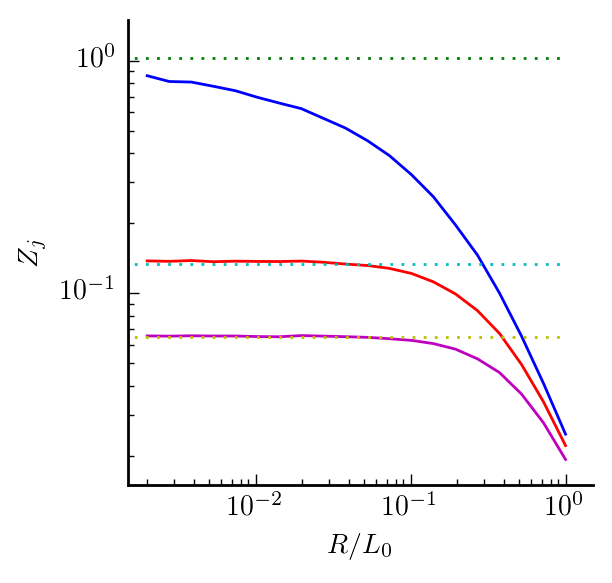

In [21]:
def PlotWinker(filename,fmin=1e-3,fmax=1e0):
    t=Table.read(filename,format="ascii.ecsv")
    d=t.meta["diameter"]
    L0=2*t["L0"]/d
    for z in [0,2,5]:
        plt.loglog(1/L0,t["Z"+str(z)],label="Z"+str(z))
        plt.loglog([fmin,fmax],[Noll[z],Noll[z]],ls="dotted")

plt.figure(figsize=(3,3))
PlotWinker("tmp/winker160731-1558.dat")
plt.ylim(1.5e-2,1.5)
plt.xlim(1.5e-3,1.5)
plt.xlabel(r"$R/L_0$")
plt.ylabel("$Z_j$")
ax=plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    top='off',      # ticks along the bottom edge are off
    bottom='on',         # ticks along the top edge are off
    )
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left='on',      # ticks along the bottom edge are off
    right='off',         # ticks along the top edge are off
    )

#plt.legend()
matplotlib.rcParams['text.usetex'] = True
plt.savefig("winker.eps",bbox_inches="tight")

In [ ]:
def sf_plot(f1,f2):
    fig1 = plt.figure(figsize=(3,3))
#Plot Data-model
    frame1=fig1.add_axes((.1,.4,.8,.5))
    #plt.subplot(2,1,1)
    t1=Table.read(f1,format="ascii.ecsv")
    r1=t1["r"]/t1.meta["r0"]
    plt.loglog(r1,t1["sf_x2"],label="x")
    plt.loglog(r1,t1["sf_y2"],label="y")
    t2=Table.read(f2,format="ascii.ecsv")
    r2=t2["r"]/t1.meta["r0"]
    plt.loglog(r2,t2["sf_x"],label="FFT")
    plt.axis([0.3,20,0.5,900])
    #plt.legend()
    plt.ylabel("$D(r)$")
    ax=plt.gca()
    ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    #plt.subplot(2,1,2)
    frame2=fig1.add_axes((.1,.1,.8,.3))
    plt.semilogx(r1,100*(t1["sf_x2"]/t1["model"]-1))
    plt.semilogx(r1,100*(t1["sf_y2"]/t1["model"]-1))
    plt.semilogx(r2,100*(t2["sf_x"]/t2["model"]-1))
    plt.axis([0.3,20,-28,15])
    plt.xlabel("$r/r0$")
    plt.ylabel(r"$\rm Error (\%)$")
    plt.yticks([-20,-10,0,10])
    plt.grid()
    ax=plt.gca()
    ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())

sf_plot("tmp/multi160731-1549.dat","tmp/mcglamery160731-1215.dat")
matplotlib.rcParams['text.usetex'] = True
plt.savefig("structure_fn.pdf",bbox_inches="tight")

In [ ]:
t=Table.read("tmp/multi160731-1013.dat",format="ascii.ecsv")
plt.semilogx(t["r"],t["sf_x2"]/t["model"])
plt.semilogx(t["r"],t["sf_y2"]/t["model"])

In [ ]:
t=Table.read("tmp/multi160731-1549.dat",format="ascii.ecsv")
plt.semilogx(t["r"],t["sf_x2"]/t["model"])
plt.semilogx(t["r"],t["sf_y2"]/t["model"])